In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#Installing dependencies
try:
    import music21
except:
    !pip install music21

# try:
#     import lilypond
# except:
#     !pip install lilypond

try: 
    from midi2audio import FluidSynth
except:
    !pip install midi2audio

In [2]:
#Importing Libraries
import tensorflow 
import numpy as np 
import pandas as pd 
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, TimeDistributed
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [3]:
#Loading the list of chopin's midi files as stream 
filepath = "/home/cyt/Senior Semester 2/Machine Learning/Project/ML_Project_Data/bach/"
#Getting midi files
all_midis= []
for i in os.listdir(filepath):
    if i.endswith(".mid"):
        tr = filepath+i
        midi = converter.parse(tr)
        all_midis.append(midi)

Next, I get the components out of these streams of MIDI files. The midi files only have the piano included as mentioned in the dataset. So the components of the file would be either piano chords or piano notes. 

**Note:** The musical notes are the building blocks of the music. It pertains to a pitch associated with a specific audio vibration. Western music utilizes twelve musical notes. 

**Chord:** A group of notes that sound good together is a chord.

The music21 stream that was created in the above cell contains both, chords and notes, we will extract them in the form of notes and obtain a series of notes in the musical composition.

**The function to get the notes:**

In [4]:
#Helping function        
def extract_notes(file):
    notes = []
    pick = None
    for j in file:
        songs = instrument.partitionByInstrument(j)
        for part in songs.parts:
            pick = part.recurse()
            for element in pick:
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                elif isinstance(element, chord.Chord):
                    notes.append(".".join(str(n) for n in element.normalOrder))

    return notes
#Getting the list of notes as Corpus
Corpus= extract_notes(all_midis)
print("Total notes in all the Chopin midis in the dataset:", len(Corpus))

Total notes in all the Chopin midis in the dataset: 4145


In [5]:
print("First fifty values in the Corpus:", Corpus[:50])

First fifty values in the Corpus: ['C4', 'E4', 'G4', 'C5', 'E5', 'G4', 'C5', 'E5', 'C4', 'E4', 'G4', 'C5', 'E5', 'G4', 'C5', 'E5', 'C4', 'D4', 'A4', 'D5', 'F5', 'A4', 'D5', 'F5', 'C4', 'D4', 'A4', 'D5', 'F5', 'A4', 'D5', 'F5', 'B3', 'D4', 'G4', 'D5', 'F5', 'G4', 'D5', 'F5', 'B3', 'D4', 'G4', 'D5', 'F5', 'G4', 'D5', 'F5', 'C4', 'E4']


All these values indicate the notes, as mentioned above.

**Printing the music sheet**

In [6]:
pip install Lilypond

Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement Lilypond
ERROR: No matching distribution found for Lilypond
Note: you may need to restart the kernel to use updated packages.


Changing working directory to: `/tmp/music21'
Processing `/tmp/music21/tmp1zhhqaw4.ly'
Parsing...
Interpreting music...[8][16][24]
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `tmp1zhhqaw4.ly.eps'...
Converting to PNG...
Layout output to `tmp1zhhqaw4.ly-1.eps'...
Layout output to `tmp1zhhqaw4.ly-2.eps'...
Layout output to `tmp1zhhqaw4.ly-3.eps'...
Writing tmp1zhhqaw4.ly-systems.texi...
Writing tmp1zhhqaw4.ly-systems.tex...
Writing tmp1zhhqaw4.ly-systems.count...
Success: compilation successfully completed


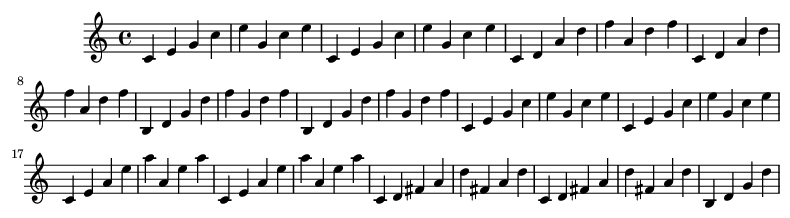

In [7]:
#First Lets write some functions that we need to look into the data
def show(music):
    display(Image(str(music.write("lily.png"))))
    
def chords_n_notes(Snippet):
    Melody = []
    offset = 0 #Incremental
    for i in Snippet:
        #If it is chord
        if ("." in i or i.isdigit()):
            chord_notes = i.split(".") #Seperating the notes in chord
            notes = [] 
            for j in chord_notes:
                inst_note=int(j)
                note_snip = note.Note(inst_note)            
                notes.append(note_snip)
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
        # pattern is a note
        else: 
            note_snip = note.Note(i)
            note_snip.offset = offset
            Melody.append(note_snip)
        # increase offset each iteration so that notes do not stack
        offset += 1
    Melody_midi = stream.Stream(Melody)   
    return Melody_midi

Melody_Snippet = chords_n_notes(Corpus[:100])
show(Melody_Snippet)

**Playing the above sheet music** 

*As I could not play a midi file on the Kaggle interface, I have created a ".wav" filetype of the same outside of this code. I am using it to create an audio interface. Let us have a listen to the data corpus.* 

In [8]:
#to play audio or corpus
print("Sample Audio From Data")
# IPython.display.Audio("../input/music-generated-lstm/Corpus_Snippet.wav") 

Sample Audio From Data


**Examine all the notes in the Corpus** 

In [9]:
#Creating a count dictionary
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))

Total unique notes in the Corpus: 114


In [10]:
#Exploring the notes dictionary
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 36.35964912280702
Most frequent note in Corpus appeared: 226 times
Least frequent note in Corpus appeared: 1 time


Clearly, there are some very rare notes in the melody; some so rare that it was played only once in the whole data. This would create a lot of problems. (I did run into most of them while writing this piece)
To spare us the error reports, let us have a look at the frequency of the notes. 
And for simplicity, I shall be eliminating some of the least occurring notes. I am sure Chopin wouldn't mind me messing with his masterpiece for science or would he? Either way, I may never know!   

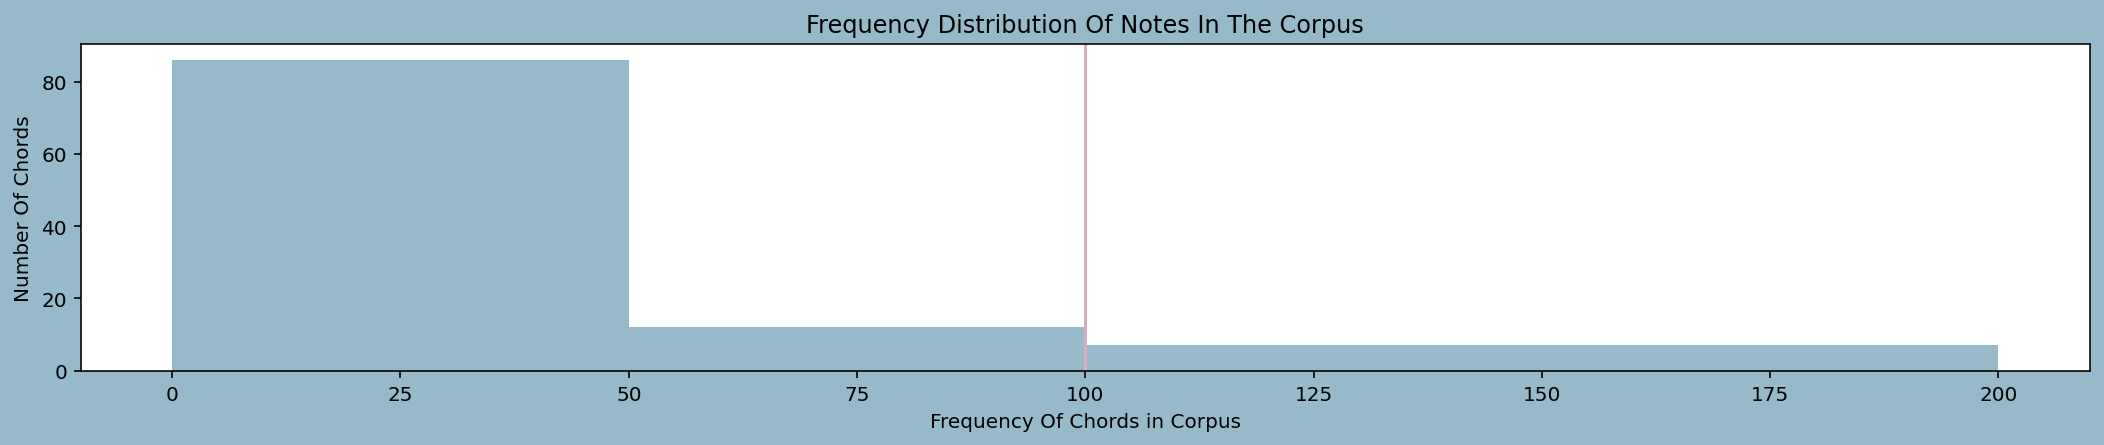

In [11]:
# Plotting the distribution of Notes
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50) 
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

I have decided, I will be taking out the notes that were played less than 100 times. I mean, if Chopin liked them he would have played it a lot more often. So I create a list of rare notes in the next section. 

In [12]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)
        
print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 98


In [13]:
#Eleminating the rare notes
for element in Corpus:
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after elemination the rare notes:", len(Corpus))

Length of Corpus after elemination the rare notes: 2981


In [14]:
# Storing all the unique characters present in my corpus to bult a mapping dic. 
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 2981
Number of unique characters: 100


**Encoding and Splitting the Corpus as Labels and Targets**

In [15]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])
    
    
L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 2941


In [16]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets) 

**Splitting Train and Seed datasets**

In [17]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [18]:
X_train.shape

(2352, 40, 1)

In [19]:
X_seed.shape

(589, 40, 1)

In [20]:
y_train.shape

(2352, 100)

In [21]:
y_seed.shape

(589, 100)

In [22]:
#Initialising the Model
model = Sequential()
#Adding layers
model.add(Bidirectional(LSTM(512, return_sequences=True), input_shape=(X.shape[1], X.shape[2])))
# model.add(LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model.add(Dense(512, activation='softmax'))
model.add(Dense(512, activation='softmax'))
model.add(Dropout(0.1))
model.add(LSTM(256))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(y.shape[1], activation='softmax'))
#Compiling the model for training  
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)


2022-05-16 22:02:35.358310: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 22:02:35.415387: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 22:02:35.415567: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-16 22:02:35.416817: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the app

In [23]:
#Model's Summary               
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 40, 1024)         2105344   
 l)                                                              
                                                                 
 dense (Dense)               (None, 40, 512)           524800    
                                                                 
 dense_1 (Dense)             (None, 40, 512)           262656    
                                                                 
 dropout (Dropout)           (None, 40, 512)           0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               787456    
                                                                 
 dense_2 (Dense)             (None, 256)               65792     
                                                        

In [24]:
#Training the Model
history = model.fit(X_train, y_train, batch_size=256, epochs=2000)

Epoch 1/2000


2022-05-16 22:02:40.280194: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-05-16 22:02:40.380118: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


10/10 [==============================] - 5s 81ms/step - loss: 4.2911
Epoch 2/2000
10/10 [==============================] - 1s 79ms/step - loss: 3.5049
Epoch 3/2000
10/10 [==============================] - 1s 77ms/step - loss: 3.4672
Epoch 4/2000
10/10 [==============================] - 1s 77ms/step - loss: 3.4552
Epoch 5/2000
10/10 [==============================] - 1s 76ms/step - loss: 3.4413
Epoch 6/2000
10/10 [==============================] - 1s 76ms/step - loss: 3.4439
Epoch 7/2000
10/10 [==============================] - 1s 77ms/step - loss: 3.4338
Epoch 8/2000
10/10 [==============================] - 1s 78ms/step - loss: 3.4290
Epoch 9/2000
10/10 [==============================] - 1s 77ms/step - loss: 3.4355
Epoch 10/2000
10/10 [==============================] - 1s 77ms/step - loss: 3.4319
Epoch 11/2000
10/10 [==============================] - 1s 78ms/step - loss: 3.4352
Epoch 12/2000
10/10 [==============================] - 1s 77ms/step - loss: 3.4397
Epoch 13/2000
10/10 [=====

Epoch 100/2000
10/10 [==============================] - 1s 79ms/step - loss: 3.3410
Epoch 101/2000
10/10 [==============================] - 1s 79ms/step - loss: 3.3403
Epoch 102/2000
10/10 [==============================] - 1s 79ms/step - loss: 3.3387
Epoch 103/2000
10/10 [==============================] - 1s 79ms/step - loss: 3.3466
Epoch 104/2000
10/10 [==============================] - 1s 80ms/step - loss: 3.3414
Epoch 105/2000
10/10 [==============================] - 1s 79ms/step - loss: 3.3395
Epoch 106/2000
10/10 [==============================] - 1s 79ms/step - loss: 3.3383
Epoch 107/2000
10/10 [==============================] - 1s 79ms/step - loss: 3.3353
Epoch 108/2000
10/10 [==============================] - 1s 79ms/step - loss: 3.3367
Epoch 109/2000
10/10 [==============================] - 1s 78ms/step - loss: 3.3377
Epoch 110/2000
10/10 [==============================] - 1s 79ms/step - loss: 3.3390
Epoch 111/2000
10/10 [==============================] - 1s 79ms/step - loss:

10/10 [==============================] - 1s 81ms/step - loss: 3.0595
Epoch 295/2000
10/10 [==============================] - 1s 81ms/step - loss: 3.0558
Epoch 296/2000
10/10 [==============================] - 1s 81ms/step - loss: 3.0405
Epoch 297/2000
10/10 [==============================] - 1s 81ms/step - loss: 3.0525
Epoch 298/2000
10/10 [==============================] - 1s 81ms/step - loss: 3.0319
Epoch 299/2000
10/10 [==============================] - 1s 81ms/step - loss: 3.0362
Epoch 300/2000
10/10 [==============================] - 1s 81ms/step - loss: 3.0709
Epoch 301/2000
10/10 [==============================] - 1s 80ms/step - loss: 3.0390
Epoch 302/2000
10/10 [==============================] - 1s 81ms/step - loss: 3.0386
Epoch 303/2000
10/10 [==============================] - 1s 81ms/step - loss: 3.0031
Epoch 304/2000
10/10 [==============================] - 1s 82ms/step - loss: 3.0132
Epoch 305/2000
10/10 [==============================] - 1s 82ms/step - loss: 3.0247
Epoch 3

10/10 [==============================] - 1s 82ms/step - loss: 2.1411
Epoch 489/2000
10/10 [==============================] - 1s 80ms/step - loss: 2.2344
Epoch 490/2000
10/10 [==============================] - 1s 80ms/step - loss: 2.1491
Epoch 491/2000
10/10 [==============================] - 1s 80ms/step - loss: 2.1092
Epoch 492/2000
10/10 [==============================] - 1s 81ms/step - loss: 2.1836
Epoch 493/2000
10/10 [==============================] - 1s 82ms/step - loss: 2.1663
Epoch 494/2000
10/10 [==============================] - 1s 82ms/step - loss: 2.1310
Epoch 495/2000
10/10 [==============================] - 1s 81ms/step - loss: 2.0367
Epoch 496/2000
10/10 [==============================] - 1s 81ms/step - loss: 2.1223
Epoch 497/2000
10/10 [==============================] - 1s 81ms/step - loss: 2.2055
Epoch 498/2000
10/10 [==============================] - 1s 80ms/step - loss: 2.2149
Epoch 499/2000
10/10 [==============================] - 1s 80ms/step - loss: 2.2432
Epoch 5

10/10 [==============================] - 1s 81ms/step - loss: 0.9116
Epoch 683/2000
10/10 [==============================] - 1s 82ms/step - loss: 1.5825
Epoch 684/2000
10/10 [==============================] - 1s 80ms/step - loss: 1.4133
Epoch 685/2000
10/10 [==============================] - 1s 80ms/step - loss: 1.0861
Epoch 686/2000
10/10 [==============================] - 1s 80ms/step - loss: 1.0027
Epoch 687/2000
10/10 [==============================] - 1s 80ms/step - loss: 0.8594
Epoch 688/2000
10/10 [==============================] - 1s 80ms/step - loss: 0.7903
Epoch 689/2000
10/10 [==============================] - 1s 80ms/step - loss: 0.8077
Epoch 690/2000
10/10 [==============================] - 1s 80ms/step - loss: 0.7781
Epoch 691/2000
10/10 [==============================] - 1s 80ms/step - loss: 0.7523
Epoch 692/2000
10/10 [==============================] - 1s 80ms/step - loss: 0.6993
Epoch 693/2000
10/10 [==============================] - 1s 80ms/step - loss: 0.6956
Epoch 6

10/10 [==============================] - 1s 81ms/step - loss: 0.1092
Epoch 877/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0940
Epoch 878/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0919
Epoch 879/2000
10/10 [==============================] - 1s 82ms/step - loss: 0.0661
Epoch 880/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0484
Epoch 881/2000
10/10 [==============================] - 1s 80ms/step - loss: 0.0453
Epoch 882/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0441
Epoch 883/2000
10/10 [==============================] - 1s 80ms/step - loss: 0.0579
Epoch 884/2000
10/10 [==============================] - 1s 80ms/step - loss: 0.0614
Epoch 885/2000
10/10 [==============================] - 1s 80ms/step - loss: 0.1200
Epoch 886/2000
10/10 [==============================] - 1s 80ms/step - loss: 0.1430
Epoch 887/2000
10/10 [==============================] - 1s 80ms/step - loss: 0.1792
Epoch 8

10/10 [==============================] - 1s 81ms/step - loss: 0.0040
Epoch 1070/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0041
Epoch 1071/2000
10/10 [==============================] - 1s 80ms/step - loss: 0.0042
Epoch 1072/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0066
Epoch 1073/2000
10/10 [==============================] - 1s 82ms/step - loss: 0.0045
Epoch 1074/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0037
Epoch 1075/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0031
Epoch 1076/2000
10/10 [==============================] - 1s 83ms/step - loss: 0.0033
Epoch 1077/2000
10/10 [==============================] - 1s 83ms/step - loss: 0.0049
Epoch 1078/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0046
Epoch 1079/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0061
Epoch 1080/2000
10/10 [==============================] - 1s 83ms/step - loss: 0.0

10/10 [==============================] - 1s 81ms/step - loss: 0.0025
Epoch 1262/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0027
Epoch 1263/2000
10/10 [==============================] - 1s 80ms/step - loss: 0.0025
Epoch 1264/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0026
Epoch 1265/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0032
Epoch 1266/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0024
Epoch 1267/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0036
Epoch 1268/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0037
Epoch 1269/2000
10/10 [==============================] - 1s 83ms/step - loss: 0.0027
Epoch 1270/2000
10/10 [==============================] - 1s 82ms/step - loss: 0.0025
Epoch 1271/2000
10/10 [==============================] - 1s 83ms/step - loss: 0.0022
Epoch 1272/2000
10/10 [==============================] - 1s 82ms/step - loss: 0.0

10/10 [==============================] - 1s 81ms/step - loss: 0.0110
Epoch 1454/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0090
Epoch 1455/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0054
Epoch 1456/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0051
Epoch 1457/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0054
Epoch 1458/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0039
Epoch 1459/2000
10/10 [==============================] - 1s 80ms/step - loss: 0.0037
Epoch 1460/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0037
Epoch 1461/2000
10/10 [==============================] - 1s 82ms/step - loss: 0.0033
Epoch 1462/2000
10/10 [==============================] - 1s 82ms/step - loss: 0.0031
Epoch 1463/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0029
Epoch 1464/2000
10/10 [==============================] - 1s 82ms/step - loss: 0.0

10/10 [==============================] - 1s 81ms/step - loss: 0.0014
Epoch 1646/2000
10/10 [==============================] - 1s 82ms/step - loss: 0.0013
Epoch 1647/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0011
Epoch 1648/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0011
Epoch 1649/2000
10/10 [==============================] - 1s 80ms/step - loss: 0.0011
Epoch 1650/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0013
Epoch 1651/2000
10/10 [==============================] - 1s 82ms/step - loss: 0.0011
Epoch 1652/2000
10/10 [==============================] - 1s 83ms/step - loss: 0.0012
Epoch 1653/2000
10/10 [==============================] - 1s 83ms/step - loss: 0.0013
Epoch 1654/2000
10/10 [==============================] - 1s 84ms/step - loss: 0.0015
Epoch 1655/2000
10/10 [==============================] - 1s 84ms/step - loss: 0.0012
Epoch 1656/2000
10/10 [==============================] - 1s 83ms/step - loss: 0.0

10/10 [==============================] - 1s 83ms/step - loss: 0.0013
Epoch 1837/2000
10/10 [==============================] - 1s 82ms/step - loss: 8.7601e-04
Epoch 1838/2000
10/10 [==============================] - 1s 83ms/step - loss: 0.0012
Epoch 1839/2000
10/10 [==============================] - 1s 83ms/step - loss: 0.0014
Epoch 1840/2000
10/10 [==============================] - 1s 83ms/step - loss: 9.2730e-04
Epoch 1841/2000
10/10 [==============================] - 1s 83ms/step - loss: 8.9818e-04
Epoch 1842/2000
10/10 [==============================] - 1s 83ms/step - loss: 9.9170e-04
Epoch 1843/2000
10/10 [==============================] - 1s 83ms/step - loss: 0.0011
Epoch 1844/2000
10/10 [==============================] - 1s 83ms/step - loss: 9.2471e-04
Epoch 1845/2000
10/10 [==============================] - 1s 83ms/step - loss: 9.8222e-04
Epoch 1846/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0011
Epoch 1847/2000
10/10 [==============================] - 

10/10 [==============================] - 1s 81ms/step - loss: 0.0016
Epoch 1933/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0011
Epoch 1934/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0011
Epoch 1935/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0011
Epoch 1936/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0010
Epoch 1937/2000
10/10 [==============================] - 1s 81ms/step - loss: 9.9570e-04
Epoch 1938/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0011
Epoch 1939/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0012
Epoch 1940/2000
10/10 [==============================] - 1s 82ms/step - loss: 0.0012
Epoch 1941/2000
10/10 [==============================] - 1s 81ms/step - loss: 0.0010
Epoch 1942/2000
10/10 [==============================] - 1s 81ms/step - loss: 9.8425e-04
Epoch 1943/2000
10/10 [==============================] - 1s 81ms/step - l

[Text(0.5, 0, 'Epochs')]

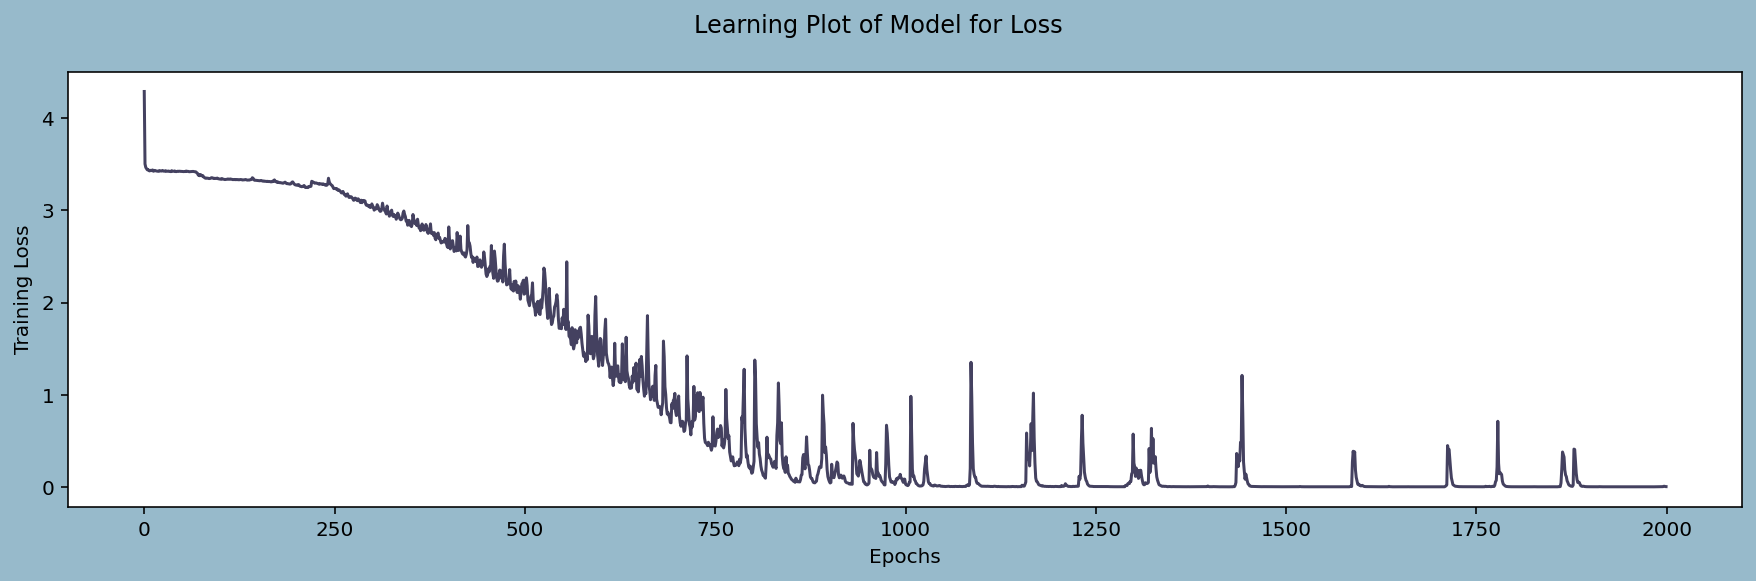

In [29]:
#Plotting the learnings 
history_df = pd.DataFrame(history.history)
fig = plt.figure(figsize=(15,4), facecolor="#97BACB")
fig.suptitle("Learning Plot of Model for Loss")
pl=sns.lineplot(data=history_df["loss"],color="#444160")
pl.set(ylabel ="Training Loss")
pl.set(xlabel ="Epochs")

**Generating the Melody**

A function to obtain the generated music

Changing working directory to: `/tmp/music21'
Processing `/tmp/music21/tmpkl6q1uzh.ly'
Parsing...
Interpreting music...[8][16][24]
Preprocessing graphical objects...
Calculating line breaks... 
Drawing systems... 
Layout output to `tmpkl6q1uzh.ly.eps'...
Converting to PNG...
Layout output to `tmpkl6q1uzh.ly-1.eps'...
Layout output to `tmpkl6q1uzh.ly-2.eps'...
Layout output to `tmpkl6q1uzh.ly-3.eps'...
Writing tmpkl6q1uzh.ly-systems.texi...
Writing tmpkl6q1uzh.ly-systems.tex...
Writing tmpkl6q1uzh.ly-systems.count...
Success: compilation successfully completed


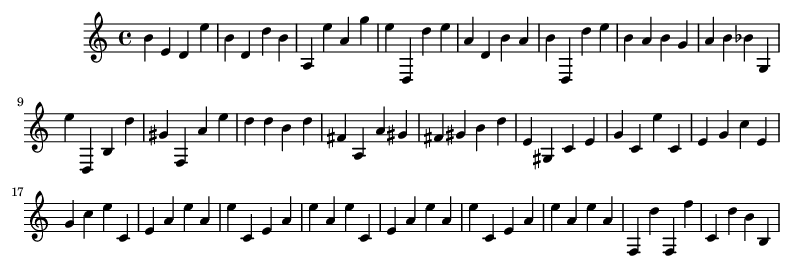

In [26]:
def Malody_Generator(Note_Count):
    seed = X_seed[np.random.randint(0,len(X_seed)-1)]
    Music = ""
    Notes_Generated=[]
    for i in range(Note_Count):
        seed = seed.reshape(1,length,1)
        prediction = model.predict(seed, verbose=0)[0]
        prediction = np.log(prediction) / 1.0 #diversity
        exp_preds = np.exp(prediction)
        prediction = exp_preds / np.sum(exp_preds)
        index = np.argmax(prediction)
        index_N = index/ float(L_symb)   
        Notes_Generated.append(index)
        Music = [reverse_mapping[char] for char in Notes_Generated]
        seed = np.insert(seed[0],len(seed[0]),index_N)
        seed = seed[1:]
    #Now, we have music in form or a list of chords and notes and we want to be a midi file.
    Melody = chords_n_notes(Music)
    Melody_midi = stream.Stream(Melody)   
    return Music,Melody_midi


#getting the Notes and Melody created by the model
Music_notes, Melody = Malody_Generator(100)
show(Melody)

This sure looks like music! To check if it sounds like music we have to listen to the MIDI file. Playing midi is crumblesome. I have saved and converted a few generated melodies to ".wav" format outside of this notebook. So let us have a listen. 

**Melody Generated Sample 1**

In [27]:
new_path = '/home/cyt/Senior Semester 2/Machine Learning/Project/Algorithm/'+'Melody_Generated.mid'
fs = FluidSynth()
fs.midi_to_audio(new_path, 'new_output.wav')

ALSA lib pcm_dsnoop.c:601:(snd_pcm_dsnoop_open) unable to open slave
ALSA lib pcm_dmix.c:1032:(snd_pcm_dmix_open) unable to open slave
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.rear
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.center_lfe
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM cards.pcm.side
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel


FluidSynth runtime version 2.2.6
Copyright (C) 2000-2022 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of Creative Technology Ltd.



jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_oss.c:397:(_snd_pcm_oss_open) Cannot open device /dev/dsp
ALSA lib pcm_a52.c:1001:(_snd_pcm_a52_open) a52 is only for playback
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_open) Invalid card 'card'
ALSA lib confmisc.c:160:(snd_config_get_card) Invalid field card
ALSA lib pcm_usb_stream.c:482:(_snd_pcm_usb_stream_op